In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "ptpm_col_example2.csv"

# Tutorial del Método SAS (Singular Spectrum Analysis)

En este tutorial revisaremos los conceptos más relevantes de la metodología de SSA. Realizaremos varios ejemplos donde primeramente un ejercicio conceptual teórico introductorio del método a una serie de tiempo muy sencilla. Posteriormente realizaremos dos ejercicios; en el primero aplicaremos el método a una serie de datos abiertos de  ventas de un producto donde aplicaremos todos los pasos de la metodología. Finalmente, relaizaremos un ejericio con datos financieros, obtenidos de la base de referencia de yahoo finance. 

**Contenido**
1. [Importación de librerías requeridas](#2)
1. [Funciones manuales](#7)
1. [Ejemplo clase: Seguro Indexado](#8)


<a id="2"></a> <br>
### 1. Importación de librerías requeridas

En este primer paso, importaremos las siguientes librerías para desarrollar este tutorial. Es posible que tengas que instalar las librerías de Rssa. 

In [2]:
library(dplyr)
library(dbplyr)
library(tidyverse)
library(psych)
#install.packages("Rssa")
library(Rssa)
#setwd("C:/Users/al.abrego/Documents/R/EF_1")
library(psych)
set.seed(123)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dbplyr::ident() masks dplyr::ident()
✖ dplyr::lag()    masks stats::lag()
✖ dbplyr::sql()   masks dplyr::sql()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Loading requi

<a id="7"></a> <br>
### 2. Funciones Manuales
Definimos algunas funciones complemetarias al paquete de Rssa que ayudan al proceso de selección para la recosntrucción.

In [3]:
##Hankelización:
UniHankel=function(Y,L){
  k<-length(Y)-L+1
  outer((1:L), (1:k), function(x,y) Y[(x+y-1)])
}

In [4]:
##Función SVD
SVD<- function(Y,L){
  X<-UniHankel(Y,L)
  svd(X)
}

In [18]:
###W-correlation
W.corr<-function(Yt,L, groups){
  m<-length(groups); w.corr<-diag(m)
  N<-length(Yt)
  w<-((N+1)-abs((N+1)/2-L)-abs((N+1)/2-1:N)-
    abs(abs((N+1)/2-L)-abs((N+1)/2-1:N)))/2
wcorr<-function(i,j){
  Y1<-SSA.Rec(Yt,L,groups[[i]])$Approximation
  Y2<-SSA.Rec(Yt,L,groups[[j]])$Approximation
  sum(w*Y1*Y2)/sqrt(sum(w*Y1^2)*sum(w*Y2^2))}
for (i in 1:(m-1)){
  for (j in (i+1):m){
    w.corr[i,j]=w.corr[j,i]=wcorr(i,j)}}
rownames(w.corr)<-colnames(w.corr)<-groups
w.corr
}

In [5]:
###Plotting Images w.corr
Plt.Img<-function(x){
  min<-min(x)
  max<-max(x)
  yLabels<-rownames(x)
  xLabels<-colnames(x)
  if( is.null (xLabels)){
    xLabels <- c(1:ncol(x))
  }
  if (is.null(yLabels)){
    yLabels <- c(1:nrow(x))
  }
  layout(matrix(data=c(1,2), nrow=1, ncol=2),
         widths=c(4,1), heights=c(1,1))
  ColorRamp<-gray( seq(1,0, length=20))
  ColorLevels<-seq(min, max, length=length(ColorRamp))
                  par(mar=c(3,5,2.5,2))
                  image(1:length(xLabels), 1:length(yLabels),
                        t(x), col=colorRamp, xlab="",
                        ylab = "", axes=FALSE, zlim=c(min, max))
                  title(main=c("Image Plot"))
                  axis(BELOW<-1, at=1:length(xLabels),
                       labels=xLabels, cex.axis=0.7)
                  axis(LEFT<-2, at=1:length(yLabels),
                       labels=yLabels, las=HORIZONTAL<-1,
                       cex.axis=0.7)
                  box()
                  par(mar=c(3,2.5, 2.5,2))
                  image(1, ColorLevels,
                        matrix(data=ColorLevels, ncol=length(ColorLevels), nrow=1),
                        col=colorRamp,
                        xlab="", ylab="",
                        xaxt="n")
                  layout(1)
}

In [6]:
##Singular Values graph
Sing.plt<-function(Y,L){
  lambda<-log(SVD(Y,L)$d)
  d<-length(lambda)
  win<-1:d
  plot.new()
  plot.window(xlim=range(win), ylim=range(lambda))
  usr=par("usr")
  rect(usr[1], usr[3], usr[2], usr[4])
  lines(win, lambda, lwd=2)
  points(win, lambda, pch=21, bg="gray")
  axis(1)
  axis(2)
  box()
  title(xlab="Number")
  title(ylab="Log.Singular Values")}


<a id="8"></a> <br>
### 3. Ejemplo Clase
Veamos ahora, un ejemplo de aplicación del proceso de descomposición espectral y pronóstico al pago de primas de seguros indexados en Colombia.
* Ref: https://www.sciencedirect.com/science/article/pii/S2212096322000286?via%3Dihub#! 

In [3]:
## SSA NEC 6K

cs2=read.csv("/kaggle/input/ptpm-col-example2-csv/ptpm_col_example2.csv", header = TRUE, sep=";")   #Base de datos del IDEAM, se incluyen CL-CL3, únicamente.
describe(cs2$Station)
#describe(cs$Alt)
sapply(cs2, function(CL) length(unique(CL)))
sapply(cs2, function(Stations) length(unique(Stations)))


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,122040,26551089,8130790,26020160,24683353,2965259,11110010,54030030,42920020,2.467582,5.772997,23274.57


Station        Month          Lat         Long          Alt         PTPM 
         135           12          134          134          106        10098 
        Year           CL        Valor Departamento    Municipio  Crop_Season 
          10            3         8970           11          113            2 
        date 
         118

Station        Month          Lat         Long          Alt         PTPM 
         135           12          134          134          106        10098 
        Year           CL        Valor Departamento    Municipio  Crop_Season 
          10            3         8970           11          113            2 
        date 
         118

In [4]:
head(cs2)
str(cs2)

,Station,Month,Lat,Long,Alt,PTPM,Year,CL,Valor,Departamento,Municipio,Crop_Season,date
,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,11110010,1,6.763333,-76.13361,1370,136,2015,2,187.5833,ANTIOQUIA,FRONTINO,Dry,1/01/2015
2,11110010,1,6.763333,-76.13361,1370,136,2015,2,134.2083,ANTIOQUIA,FRONTINO,Dry,1/01/2015
3,11110010,1,6.763333,-76.13361,1370,136,2015,2,136.0000,ANTIOQUIA,FRONTINO,Dry,1/01/2015
4,11110010,1,6.763333,-76.13361,1370,136,2015,2,125.6667,ANTIOQUIA,FRONTINO,Dry,1/01/2015
5,11110010,1,6.763333,-76.13361,1370,136,2015,2,391.0000,ANTIOQUIA,FRONTINO,Dry,1/01/2015
6,11110010,1,6.763333,-76.13361,1370,136,2015,2,241.5417,ANTIOQUIA,FRONTINO,Dry,1/01/2015


'data.frame':	122040 obs. of  13 variables:
 $ Station     : int  11110010 11110010 11110010 11110010 11110010 11110010 11110010 11110010 11110010 11110010 ...
 $ Month       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Lat         : num  6.76 6.76 6.76 6.76 6.76 ...
 $ Long        : num  -76.1 -76.1 -76.1 -76.1 -76.1 ...
 $ Alt         : int  1370 1370 1370 1370 1370 1370 1370 1370 1370 1370 ...
 $ PTPM        : num  136 136 136 136 136 136 136 136 391 391 ...
 $ Year        : int  2015 2015 2015 2015 2015 2015 2015 2015 2012 2012 ...
 $ CL          : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Valor       : num  188 134 136 126 391 ...
 $ Departamento: chr  "ANTIOQUIA" "ANTIOQUIA" "ANTIOQUIA" "ANTIOQUIA" ...
 $ Municipio   : chr  "FRONTINO" "FRONTINO" "FRONTINO" "FRONTINO" ...
 $ Crop_Season : chr  "Dry" "Dry" "Dry" "Dry" ...
 $ date        : chr  "1/01/2015" "1/01/2015" "1/01/2015" "1/01/2015" ...


In [5]:
cs2$Date<- as.Date(cs2$date, format='%d/%m/%Y')
head(cs2)
tail(cs2)

,Station,Month,Lat,Long,Alt,PTPM,Year,CL,Valor,Departamento,Municipio,Crop_Season,date,Date
,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<date>
1,11110010,1,6.763333,-76.13361,1370,136,2015,2,187.5833,ANTIOQUIA,FRONTINO,Dry,1/01/2015,2015-01-01
2,11110010,1,6.763333,-76.13361,1370,136,2015,2,134.2083,ANTIOQUIA,FRONTINO,Dry,1/01/2015,2015-01-01
3,11110010,1,6.763333,-76.13361,1370,136,2015,2,136.0000,ANTIOQUIA,FRONTINO,Dry,1/01/2015,2015-01-01
4,11110010,1,6.763333,-76.13361,1370,136,2015,2,125.6667,ANTIOQUIA,FRONTINO,Dry,1/01/2015,2015-01-01
5,11110010,1,6.763333,-76.13361,1370,136,2015,2,391.0000,ANTIOQUIA,FRONTINO,Dry,1/01/2015,2015-01-01
6,11110010,1,6.763333,-76.13361,1370,136,2015,2,241.5417,ANTIOQUIA,FRONTINO,Dry,1/01/2015,2015-01-01


,Station,Month,Lat,Long,Alt,PTPM,Year,CL,Valor,Departamento,Municipio,Crop_Season,date,Date
,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<date>
122035,54030030,9,4.495722,-76.35222,1196,32.45833,2018,3,13.87500,VALLE_DEL_CAUCA,EL_DOVIO,Wet,1/09/2018,2018-09-01
122036,54030030,9,4.495722,-76.35222,1196,32.45833,2018,3,24.66667,VALLE_DEL_CAUCA,EL_DOVIO,Wet,1/09/2018,2018-09-01
122037,54030030,9,4.495722,-76.35222,1196,32.45833,2018,3,0.00000,VALLE_DEL_CAUCA,EL_DOVIO,Wet,1/09/2018,2018-09-01
122038,54030030,9,4.495722,-76.35222,1196,32.45833,2018,3,43.00000,VALLE_DEL_CAUCA,EL_DOVIO,Wet,1/09/2018,2018-09-01
122039,54030030,9,4.495722,-76.35222,1196,32.45833,2018,3,32.45833,VALLE_DEL_CAUCA,EL_DOVIO,Wet,1/09/2018,2018-09-01
122040,54030030,9,4.495722,-76.35222,1196,32.45833,2018,3,40.12500,VALLE_DEL_CAUCA,EL_DOVIO,Wet,1/09/2018,2018-09-01


In [11]:
cs2_ssa=cs2[,c(-13)]
tail(cs2_ssa)
str(cs2_ssa)

,Station,Month,Lat,Long,Alt,PTPM,Year,CL,Valor,Departamento,Municipio,Crop_Season,Date
,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<date>
122035,54030030,9,4.495722,-76.35222,1196,32.45833,2018,3,13.87500,VALLE_DEL_CAUCA,EL_DOVIO,Wet,2018-09-01
122036,54030030,9,4.495722,-76.35222,1196,32.45833,2018,3,24.66667,VALLE_DEL_CAUCA,EL_DOVIO,Wet,2018-09-01
122037,54030030,9,4.495722,-76.35222,1196,32.45833,2018,3,0.00000,VALLE_DEL_CAUCA,EL_DOVIO,Wet,2018-09-01
122038,54030030,9,4.495722,-76.35222,1196,32.45833,2018,3,43.00000,VALLE_DEL_CAUCA,EL_DOVIO,Wet,2018-09-01
122039,54030030,9,4.495722,-76.35222,1196,32.45833,2018,3,32.45833,VALLE_DEL_CAUCA,EL_DOVIO,Wet,2018-09-01
122040,54030030,9,4.495722,-76.35222,1196,32.45833,2018,3,40.12500,VALLE_DEL_CAUCA,EL_DOVIO,Wet,2018-09-01


'data.frame':	122040 obs. of  13 variables:
 $ Station     : int  11110010 11110010 11110010 11110010 11110010 11110010 11110010 11110010 11110010 11110010 ...
 $ Month       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Lat         : num  6.76 6.76 6.76 6.76 6.76 ...
 $ Long        : num  -76.1 -76.1 -76.1 -76.1 -76.1 ...
 $ Alt         : int  1370 1370 1370 1370 1370 1370 1370 1370 1370 1370 ...
 $ PTPM        : num  136 136 136 136 136 136 136 136 391 391 ...
 $ Year        : int  2015 2015 2015 2015 2015 2015 2015 2015 2012 2012 ...
 $ CL          : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Valor       : num  188 134 136 126 391 ...
 $ Departamento: chr  "ANTIOQUIA" "ANTIOQUIA" "ANTIOQUIA" "ANTIOQUIA" ...
 $ Municipio   : chr  "FRONTINO" "FRONTINO" "FRONTINO" "FRONTINO" ...
 $ Crop_Season : chr  "Dry" "Dry" "Dry" "Dry" ...
 $ Date        : Date, format: "2015-01-01" "2015-01-01" ...


In [12]:
library(dplyr)
cs2_ssa$CL =as.character(cs2_ssa$CL)

In [8]:
####################### MODELO PAGOS
indice <- function(x, lower_limit, lower_threshold, upper_limit, upper_threshold, max_indemnity){
  cond1 <- x <= lower_limit | x >= upper_limit
  cond2 <- x >= lower_threshold & x <= upper_threshold
  pay1 <- (lower_threshold-x)/(lower_threshold-lower_limit)*max_indemnity
  pay2 <- (x-upper_threshold)/(upper_limit-upper_threshold)*max_indemnity
  output <- ifelse(cond1, max_indemnity, 
                   ifelse(cond2, 0, 
                          ifelse( pay1, pay2)
                   )
  )
  return(output)
}


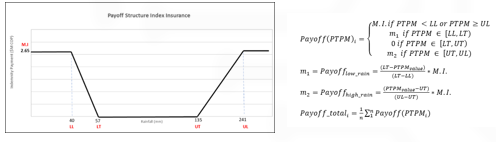


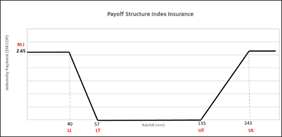
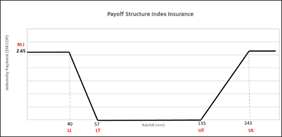
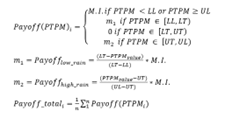
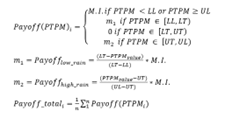
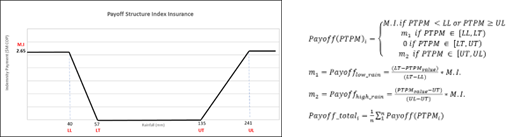
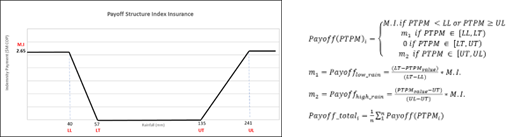
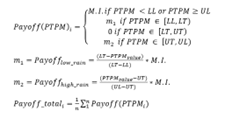
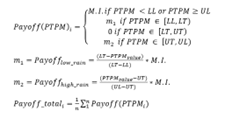
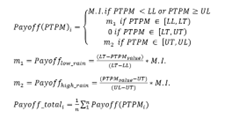
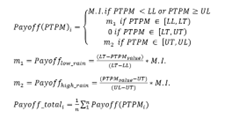

In [13]:
#########indice
###variables
max_indemnity=3000000
lower_limit = 35
lower_threshold = 60
upper_threshold = 140
upper_limit = 250
####################

In [14]:
##Promedio de lluvia por cluster
library(dbplyr)
library(plyr)
library(tidyverse)
library(magrittr)
library(psych)

cl_ptpm2<-ddply(cs2_ssa, c("CL", "Date", "Crop_Season"), summarise,
               mean_pt = mean(PTPM)) %>% na.omit()
head(cl_ptpm2)
tail(cl_ptpm2)
str(cl_ptpm2)

,CL,Date,Crop_Season,mean_pt
,<chr>,<date>,<chr>,<dbl>
1,1,2010-01-01,Dry,69.90370
2,1,2010-02-01,Dry,23.66667
3,1,2010-03-01,Dry,56.60000
4,1,2010-04-01,Wet,124.90602
5,1,2010-05-01,Wet,186.47577
6,1,2010-06-01,Wet,215.62211


,CL,Date,Crop_Season,mean_pt
,<chr>,<date>,<chr>,<dbl>
399,3,2019-06-01,Dry,209.219957
400,3,2019-07-01,Dry,80.322917
401,3,2019-08-01,Dry,59.258035
402,3,2019-09-01,Dry,32.434091
403,3,2019-09-01,Wet,8.069231
404,3,2019-10-01,Wet,1.476042


'data.frame':	404 obs. of  4 variables:
 $ CL         : chr  "1" "1" "1" "1" ...
 $ Date       : Date, format: "2010-01-01" "2010-02-01" ...
 $ Crop_Season: chr  "Dry" "Dry" "Dry" "Wet" ...
 $ mean_pt    : num  69.9 23.7 56.6 124.9 186.5 ...


In [15]:
#--------Separamos CL1
###
#CL1:
scl1_Wet <- dplyr::filter(cl_ptpm2, CL == "1" & Crop_Season == 'Wet')
describe(scl1_Wet$mean_pt)
head(scl1_Wet)
scl1_Dry <- dplyr::filter(cl_ptpm2, CL == "1" & Crop_Season == 'Dry')
describe(scl1_Dry$mean_pt)
head(scl1_Dry)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,79,174.2112,50.08,171.8036,173.6626,56.77288,15.16125,296.6819,281.5207,-0.04243183,0.1854065,5.63444


,CL,Date,Crop_Season,mean_pt
,<chr>,<date>,<chr>,<dbl>
1,1,2010-04-01,Wet,124.9060
2,1,2010-05-01,Wet,186.4758
3,1,2010-06-01,Wet,215.6221
4,1,2010-07-01,Wet,192.1511
5,1,2010-08-01,Wet,223.0372
6,1,2010-09-01,Wet,184.0021


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,39,98.9169,54.22109,87.51324,94.13956,47.73399,23.66667,230.4897,206.823,0.8029971,-0.2342153,8.682322


,CL,Date,Crop_Season,mean_pt
,<chr>,<date>,<chr>,<dbl>
1,1,2010-01-01,Dry,69.90370
2,1,2010-02-01,Dry,23.66667
3,1,2010-03-01,Dry,56.60000
4,1,2010-12-01,Dry,226.78733
5,1,2011-01-01,Dry,125.48378
6,1,2011-02-01,Dry,55.31711


**Ejemplo de SSA Multivariado**

Aplicado a los clusters, consderando todos estos en un proceso.

In [18]:
##########################################
### ----------------------------------------      Multivariate SSA
cs2=read.csv("/kaggle/input/ptpm-col-example2-csv/ptpm_col_example2.csv", header = TRUE, sep=";")
sapply(cs2, function(CL) length(unique(CL)))
sapply(cs2, function(Stations) length(unique(Stations)))

head(cs2)
str(cs2)
cs2$Date<- as.Date(cs2$date, format='%d/%m/%Y')
#head(cs2)
#tail(cs2)
cs2_ssa=cs2[,c(-13)]
#head(cs2_ssa)
str(cs2_ssa)
library(dplyr)
cs2_ssa$CL =as.character(cs2_ssa$CL)

Station        Month          Lat         Long          Alt         PTPM 
         135           12          134          134          106        10098 
        Year           CL        Valor Departamento    Municipio  Crop_Season 
          10            3         8970           11          113            2 
        date 
         118

Station        Month          Lat         Long          Alt         PTPM 
         135           12          134          134          106        10098 
        Year           CL        Valor Departamento    Municipio  Crop_Season 
          10            3         8970           11          113            2 
        date 
         118

,Station,Month,Lat,Long,Alt,PTPM,Year,CL,Valor,Departamento,Municipio,Crop_Season,date
,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,11110010,1,6.763333,-76.13361,1370,136,2015,2,187.5833,ANTIOQUIA,FRONTINO,Dry,1/01/2015
2,11110010,1,6.763333,-76.13361,1370,136,2015,2,134.2083,ANTIOQUIA,FRONTINO,Dry,1/01/2015
3,11110010,1,6.763333,-76.13361,1370,136,2015,2,136.0000,ANTIOQUIA,FRONTINO,Dry,1/01/2015
4,11110010,1,6.763333,-76.13361,1370,136,2015,2,125.6667,ANTIOQUIA,FRONTINO,Dry,1/01/2015
5,11110010,1,6.763333,-76.13361,1370,136,2015,2,391.0000,ANTIOQUIA,FRONTINO,Dry,1/01/2015
6,11110010,1,6.763333,-76.13361,1370,136,2015,2,241.5417,ANTIOQUIA,FRONTINO,Dry,1/01/2015


'data.frame':	122040 obs. of  13 variables:
 $ Station     : int  11110010 11110010 11110010 11110010 11110010 11110010 11110010 11110010 11110010 11110010 ...
 $ Month       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Lat         : num  6.76 6.76 6.76 6.76 6.76 ...
 $ Long        : num  -76.1 -76.1 -76.1 -76.1 -76.1 ...
 $ Alt         : int  1370 1370 1370 1370 1370 1370 1370 1370 1370 1370 ...
 $ PTPM        : num  136 136 136 136 136 136 136 136 391 391 ...
 $ Year        : int  2015 2015 2015 2015 2015 2015 2015 2015 2012 2012 ...
 $ CL          : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Valor       : num  188 134 136 126 391 ...
 $ Departamento: chr  "ANTIOQUIA" "ANTIOQUIA" "ANTIOQUIA" "ANTIOQUIA" ...
 $ Municipio   : chr  "FRONTINO" "FRONTINO" "FRONTINO" "FRONTINO" ...
 $ Crop_Season : chr  "Dry" "Dry" "Dry" "Dry" ...
 $ date        : chr  "1/01/2015" "1/01/2015" "1/01/2015" "1/01/2015" ...
'data.frame':	122040 obs. of  13 variables:
 $ Station     : int  11110010 11110010 11110010 11110010 1111001

In [19]:
##Promedio de lluvia por cluster
library(dbplyr)
library(plyr)
library(tidyverse)
library(magrittr)
library(psych)
#Todo WET & DRY:
cl_ptpm2<-ddply(cs2_ssa, c( "Date", "Crop_Season"), summarise,
                mean_pt = mean(PTPM)) %>% na.omit()
head(cl_ptpm2)
tail(cl_ptpm2)
str(cl_ptpm2)

,Date,Crop_Season,mean_pt
,<date>,<chr>,<dbl>
1,2010-01-01,Dry,104.1757
2,2010-01-01,Wet,151.4624
3,2010-02-01,Dry,34.4104
4,2010-02-01,Wet,53.9128
5,2010-03-01,Dry,89.1803
6,2010-03-01,Wet,118.9331


,Date,Crop_Season,mean_pt
,<date>,<chr>,<dbl>
192,2019-07-01,Wet,99.434832
193,2019-08-01,Dry,121.401084
194,2019-08-01,Wet,123.279891
195,2019-09-01,Dry,32.434091
196,2019-09-01,Wet,72.313718
197,2019-10-01,Wet,8.680667


'data.frame':	197 obs. of  3 variables:
 $ Date       : Date, format: "2010-01-01" "2010-01-01" ...
 $ Crop_Season: chr  "Dry" "Wet" "Dry" "Wet" ...
 $ mean_pt    : num  104.2 151.5 34.4 53.9 89.2 ...


In [20]:
###Filtramos por temporada Wet and Dry
cl_ptpm2_dry<- dplyr::filter(cl_ptpm2, Crop_Season=="Dry")
cl_ptpm2_wet<- dplyr::filter(cl_ptpm2, Crop_Season=="Wet")
colnames(cl_ptpm2_dry)<-c("Date", "Crop_dry","ptpm_dry")
colnames(cl_ptpm2_wet)<-c("Date", "Crop_wet","ptpm_wet")
str(cl_ptpm2_dry)
str(cl_ptpm2_wet)
head(cl_ptpm2_dry)

'data.frame':	79 obs. of  3 variables:
 $ Date    : Date, format: "2010-01-01" "2010-02-01" ...
 $ Crop_dry: chr  "Dry" "Dry" "Dry" "Dry" ...
 $ ptpm_dry: num  104.2 34.4 89.2 184.9 212.6 ...
'data.frame':	118 obs. of  3 variables:
 $ Date    : Date, format: "2010-01-01" "2010-02-01" ...
 $ Crop_wet: chr  "Wet" "Wet" "Wet" "Wet" ...
 $ ptpm_wet: num  151.5 53.9 118.9 134.3 249.2 ...


,Date,Crop_dry,ptpm_dry
,<date>,<chr>,<dbl>
1,2010-01-01,Dry,104.1757
2,2010-02-01,Dry,34.4104
3,2010-03-01,Dry,89.1803
4,2010-06-01,Dry,184.9012
5,2010-07-01,Dry,212.6256
6,2010-08-01,Dry,267.2747


In [21]:
## Unimos base por fechas y pasamos a formato columnas
rain= merge.data.frame(cl_ptpm2_dry,cl_ptpm2_wet, join = 'left') %>%na.omit()
head(rain)
str(rain)
srain=rain[,c(3,5)]


,Date,Crop_dry,ptpm_dry,Crop_wet,ptpm_wet
,<date>,<chr>,<dbl>,<chr>,<dbl>
1,2010-01-01,Dry,104.1757,Wet,151.4624
2,2010-02-01,Dry,34.4104,Wet,53.9128
3,2010-03-01,Dry,89.1803,Wet,118.9331
4,2010-06-01,Dry,184.9012,Wet,280.4541
5,2010-07-01,Dry,212.6256,Wet,192.1511
6,2010-08-01,Dry,267.2747,Wet,223.0372


'data.frame':	79 obs. of  5 variables:
 $ Date    : Date, format: "2010-01-01" "2010-02-01" ...
 $ Crop_dry: chr  "Dry" "Dry" "Dry" "Dry" ...
 $ ptpm_dry: num  104.2 34.4 89.2 184.9 212.6 ...
 $ Crop_wet: chr  "Wet" "Wet" "Wet" "Wet" ...
 $ ptpm_wet: num  151.5 53.9 118.9 280.5 192.2 ...


 Time-Series [1:79, 1:2] from 2010 to 2016: 104.2 34.4 89.2 184.9 212.6 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "ptpm_dry" "ptpm_wet"


,ptpm_dry,ptpm_wet
Jan 2010,104.1757,151.4624
Feb 2010,34.4104,53.9128
Mar 2010,89.1803,118.9331
Apr 2010,184.9012,280.4541
May 2010,212.6256,192.1511
Jun 2010,267.2747,223.0372


,ptpm_dry,ptpm_wet
Feb 2016,85.61998,130.19300
Mar 2016,142.15702,138.80106
Apr 2016,210.25119,304.79117
May 2016,127.94635,99.43483
Jun 2016,121.40108,123.27989
Jul 2016,32.43409,72.31372


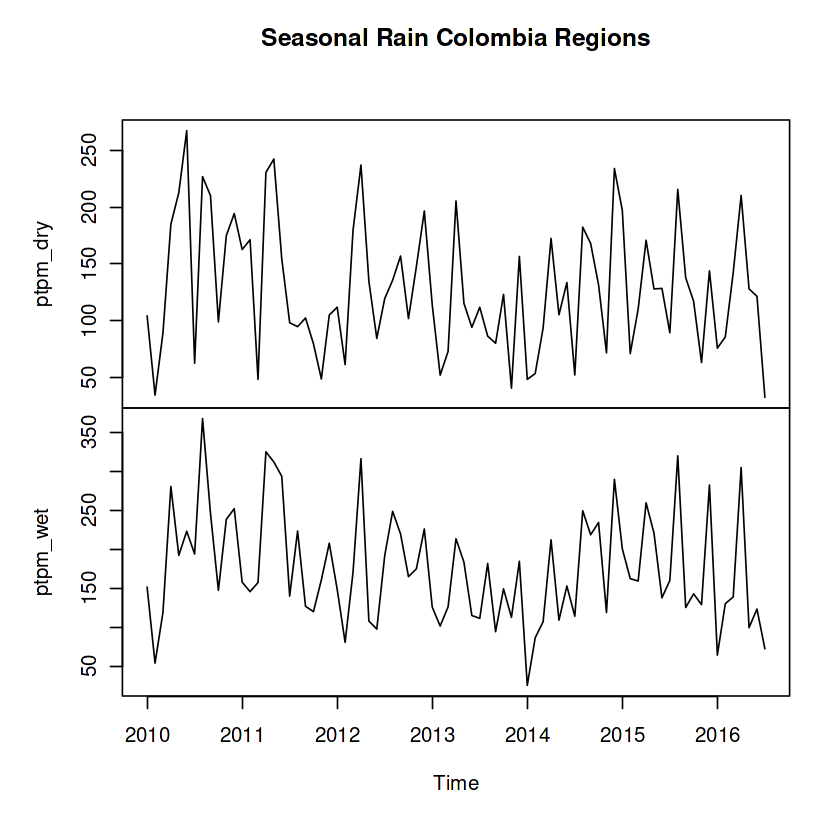

In [22]:
##Formato ts
raints = ts(srain, start=c(2010,01), frequency = 12)
str(raints)
head(raints)
tail(raints)
plot(raints, main = "Seasonal Rain Colombia Regions")

In [23]:
install.packages("Rssa")
library(Rssa)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [24]:
##----Aplicación de SSA
## ###FASE 1. Descomposici?n
rain_ssa=ssa(raints, kind = "mssa")
summary(rain_ssa)


Call:
ssa(x = raints, kind = "mssa")

Series length: 79, 79,	Window length: 40,	SVD method: eigen
Special triples:  0

Computed:
Eigenvalues: 40,	Eigenvectors: 40,	Factor vectors: 0

Precached: 0 elementary series (0 MiB)

Overall memory consumption (estimate): 0.01942 MiB


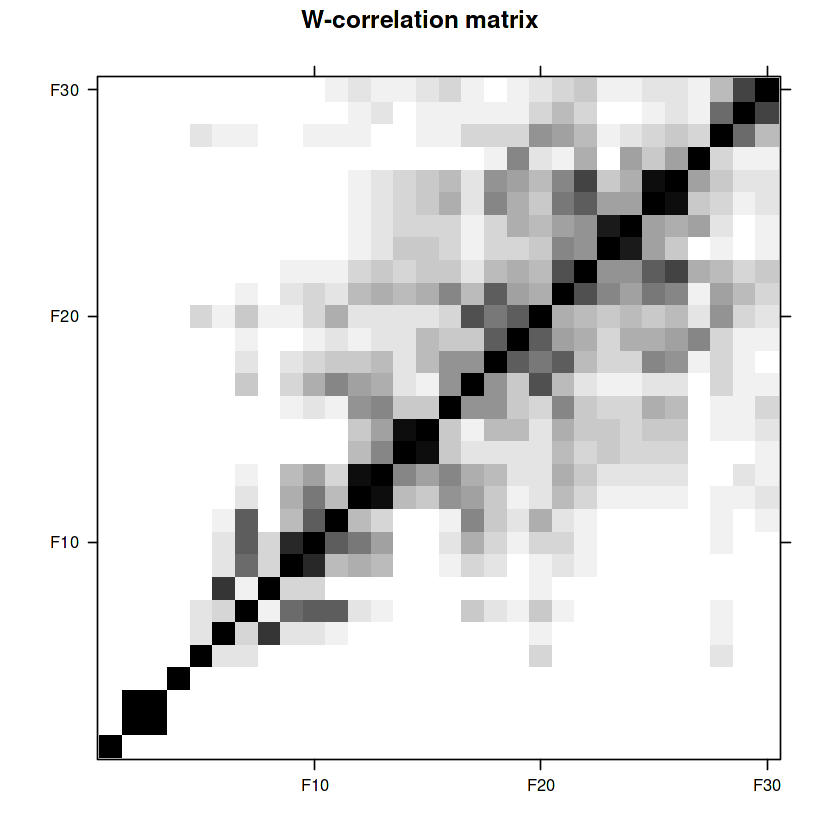

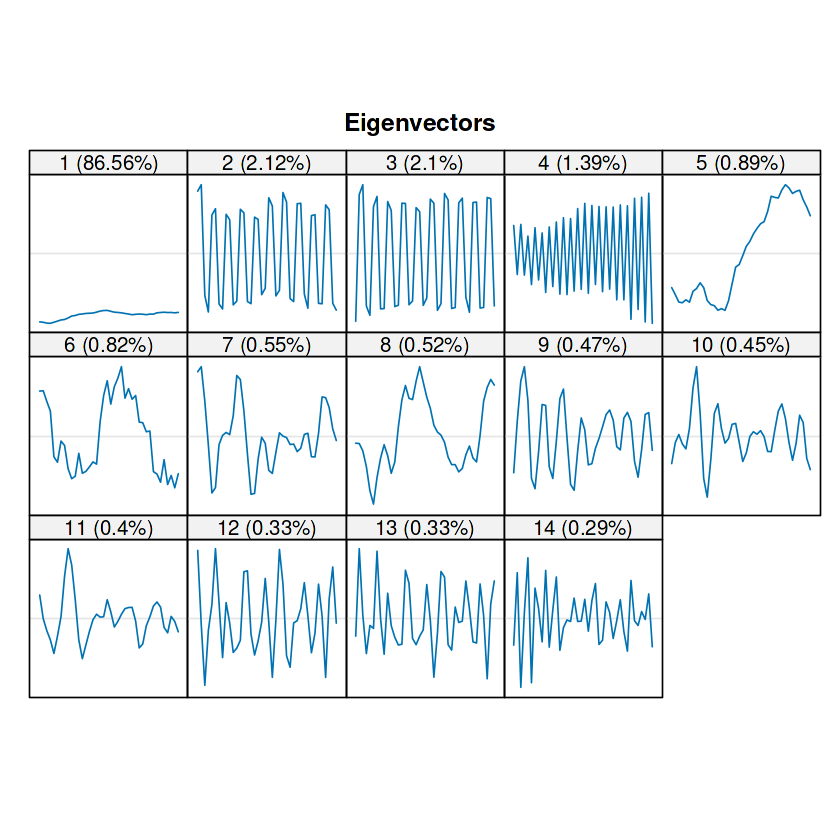

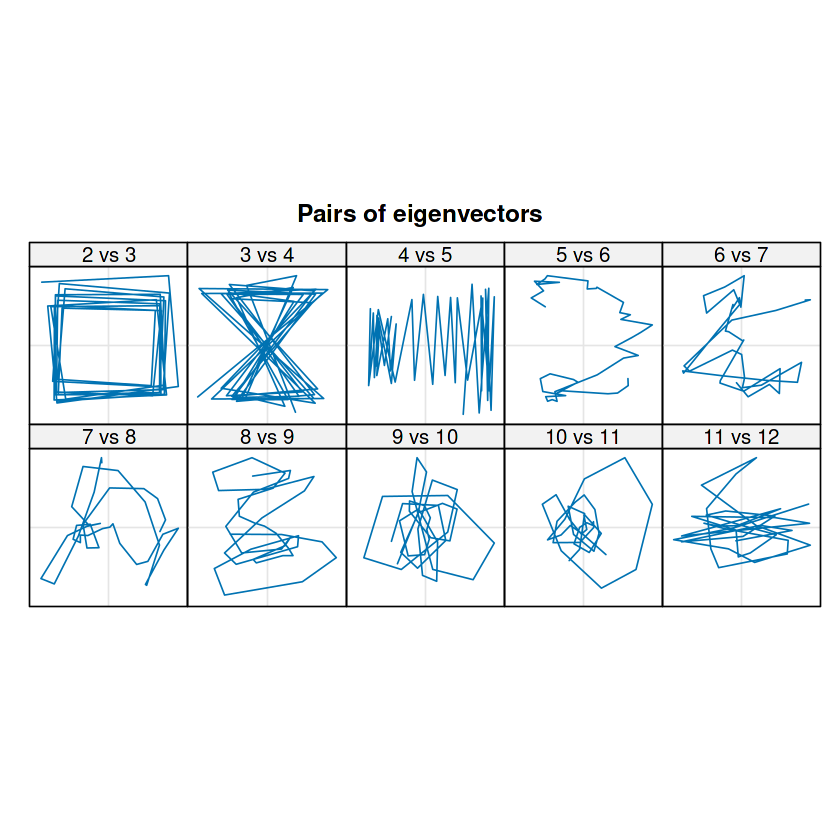

In [25]:
##W-corrr matrix
wfort<-wcor(rain_ssa, groups=1:30)
plot(wcor(rain_ssa, groups = 1:30), scales=list(at=c(10, 20, 30)))

plot(rain_ssa, type="vectors", idx=1:14)
plot(rain_ssa, type= "paired", idx=2:11, plot.contrib = FALSE)  #los v?rtices son la frecuencia, determinan el periodo de las ondas seno.

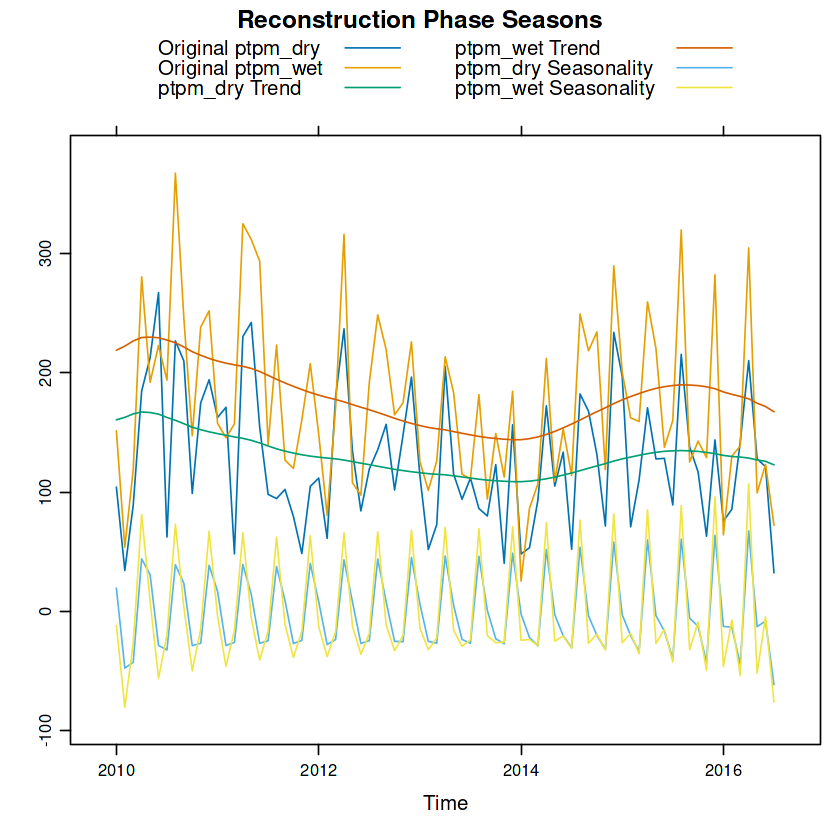

In [26]:
### Fase de Reconstruccion:
r.cl_season= reconstruct(rain_ssa, groups= list(Trend=c(1,5), Seasonality=c(2:3, 3:4)))
plot(r.cl_season, add.residuals=FALSE, add.original=TRUE, superpose=TRUE, plot.method="xyplot", main="Reconstruction Phase Seasons",
    superpose=TRUE, auto.key=list(columns=2))

 Time-Series [1:24, 1:2] from 2017 to 2018: 199.1 108.6 128.6 67.3 203.2 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "ptpm_dry" "ptpm_wet"


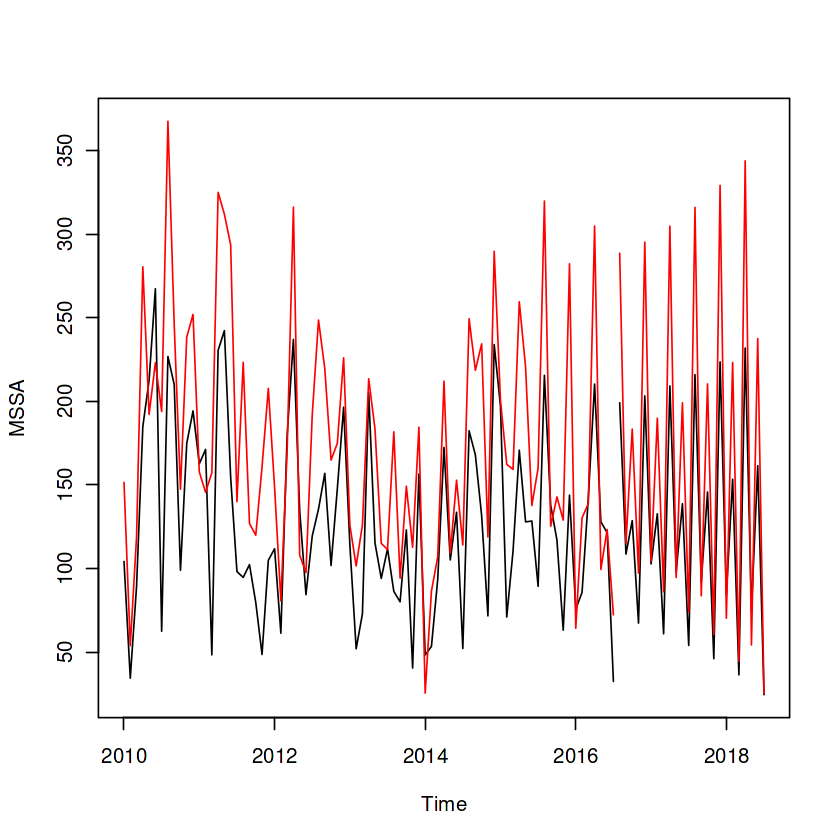

In [30]:
#### Analisis Payoff por componentes Tendencia y Estacionalidad
r_season_dry <- r.cl_season$Seasonality[,"ptpm_dry"] + r.cl_season$Trend[,"ptpm_dry"]  #SEnAL DRY
r_season_wet <- r.cl_season$Seasonality[,"ptpm_wet"] + r.cl_season$Trend[,"ptpm_wet"]  #SEnAL WET
###
#Forecast
set.seed(3)
for3fort<-rforecast(rain_ssa, groups=list(1:5), len=24, only.new=TRUE)
str(for3fort)
plot(cbind(raints,for3fort), plot.type = "single", col = c("black", "red"), ylab= "MSSA")

In [31]:
install.packages("logKDE")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,1000,136.4494,43.48032,136.4494,136.4494,55.7995,61.25216,211.6466,150.3945,-2.157529e-16,-1.203601,1.374968


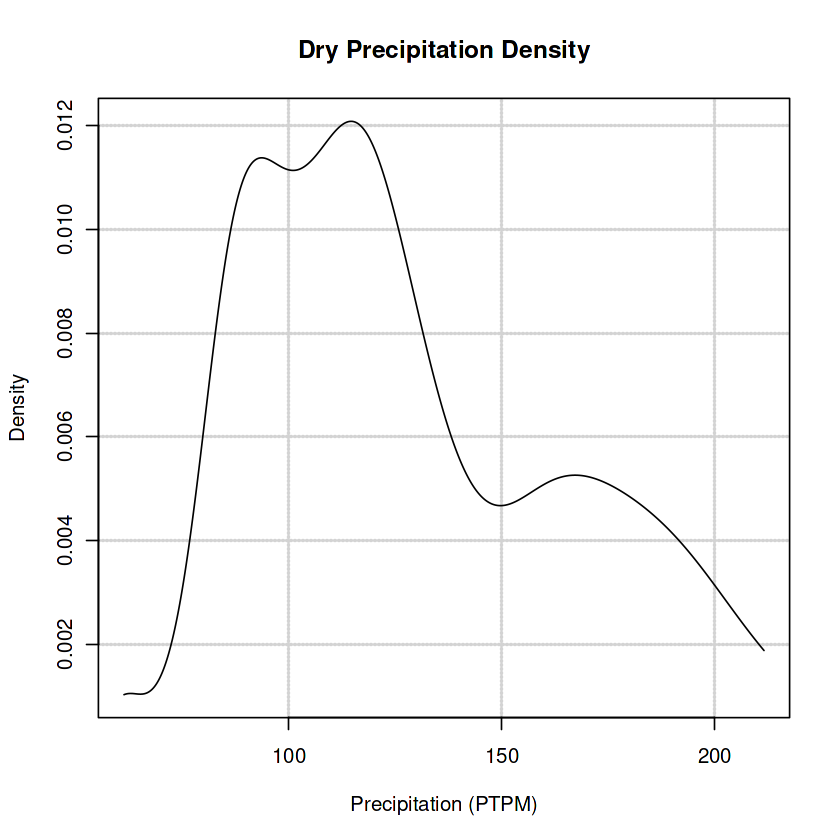

In [32]:
###Payouts
#Dry
###kernel density
library(logKDE)
fitcl_dry=logdensity(r_season_dry, kernel = "logistic", n=1000)
plot( fitcl_dry, main = " Dry Precipitation Density ",
      xlab="Precipitation (PTPM)", ylab="Density", 
      panel.first=grid(nx = NULL, ny = NULL, lwd=2, col = "lightgray", lty = "dotted"))

fitcl_dry$x <- ifelse(fitcl_dry$x < 0, .Machine$double.eps, fitcl_dry$x) 
describe(fitcl_dry$x)

datacl_dry <- as.data.frame(x = fitcl_dry$x)

In [33]:
## Cálxulo indemnización, aplicamos función de pagos para datos en la temporada Dry:
payoffcl_season_dry <- indice(datacl_dry$`fitcl_dry$x`, lower_limit, lower_threshold, upper_limit, upper_threshold, max_indemnity)

###Pago Indemnity payment due:
mean(payoffcl_season_dry)
sd(payoffcl_season_dry)

Percent_indemnizationcl_season_dry=(mean(payoffcl_season_dry)/max_indemnity)*100
Percent_indemnizationcl_season_dry

[1] 465945.7

[1] 625215.5

[1] 15.53152

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,1000,201.1784,63.59775,201.1784,201.1784,81.61676,91.18896,311.1678,219.9788,2.339782e-16,-1.203601,2.011138


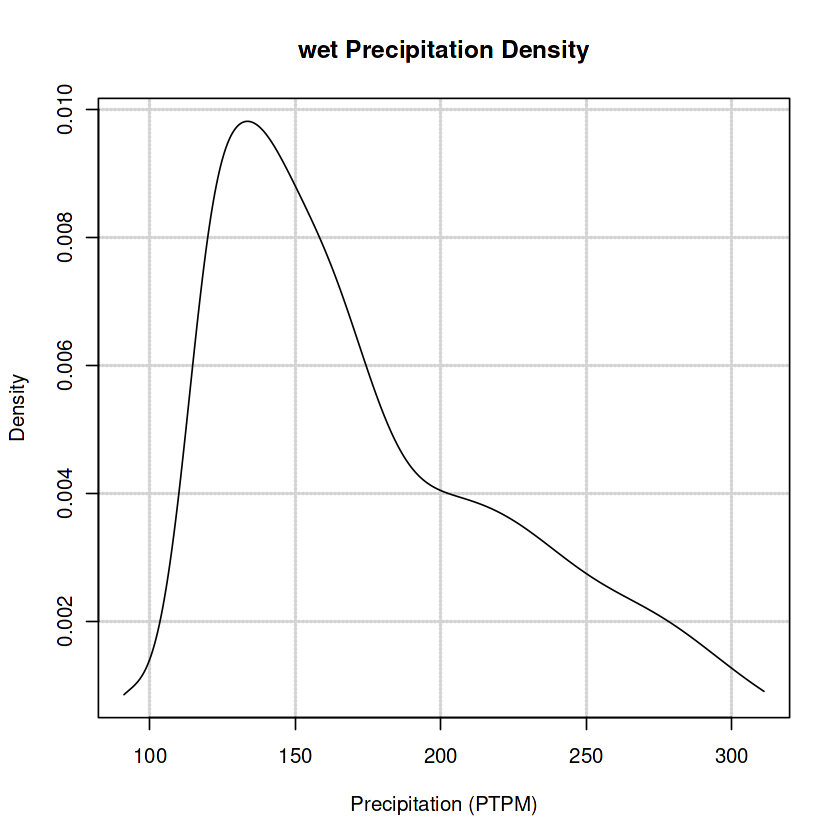

In [34]:
###Pagos para temporada Wet:
#WET
###kernel density
library(logKDE)
fitcl_wet=logdensity(r_season_wet, kernel = "logistic", n=1000)
plot( fitcl_wet, main = " wet Precipitation Density ",
      xlab="Precipitation (PTPM)", ylab="Density", 
      panel.first=grid(nx = NULL, ny = NULL, lwd=2, col = "lightgray", lty = "dotted"))

fitcl_wet$x <- ifelse(fitcl_wet$x < 0, .Machine$double.eps, fitcl_wet$x) 
describe(fitcl_wet$x)

datacl_wet <- as.data.frame(x = fitcl_wet$x)

In [35]:
##Payoff
payoffcl_season_wet <- indice(datacl_wet$`fitcl_wet$x`, lower_limit, lower_threshold, upper_limit, upper_threshold, max_indemnity)

###Pago Indemnity payment due:
mean(payoffcl_season_wet)
sd(payoffcl_season_wet)

Percent_indemnizationcl_season_wet=(mean(payoffcl_season_wet)/max_indemnity)*100
Percent_indemnizationcl_season_wet

[1] 1584174

[1] 1222738

[1] 52.80581

Como podemos ver, la proporción de pagos máximos de indemnizaciones, alcanzan en la temporada de lluvias, el 52% por mes. En esta temporada, fenomenos de la niña se presentaron. Este cluster, representa el de menor riesgo, entre los 6 que analizó el artículo.
Ref: https://www.sciencedirect.com/science/article/pii/S2212096322000286?via%3Dihub#!